# Multiple Linear Regression

Multiple linear regression is the extension of simple linear regression to multiple explanatory variables and picks up means by group along the way.  Hence, multiple linear regression seeks to explain a single, numerical response variable using multiple explanatory variables of different types.

It helps to immediately visualize what the combination of multiple explanatory variables of different types adds to simple linear regression.  Consider the dataset $\texttt{carnivora}$.  We'll fit four different models using body weight $\texttt{SW}$ as the numerical response variable, birth weight $\texttt{BW}$ as a numerical explanatory variable, and Super Family as a categorical explanatory variable.  The four models are simple linear regression, multiple linear regression with unique intercepts for the levels of the categorical explanatory variable, multiple linear regression with unique slopes for the levels of the categorical explanatory variable, and multiple linear regression with unique intercepts and unique slopes for the levels of the categorical explanatory variable.

In [1]:
import numpy as np
import pandas as pd
import bplot as bp
from scipy.optimize import minimize
from scipy.stats import norm as normal
import patsy

bp.LaTeX()

In [2]:
carnivora = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/master/carnivora.csv")
carn = carnivora[["BW", "SW", "SuperFamily"]].dropna() # order is important

Below is code for *four different models*.  In order, the models specify simple linear regression across birth weight `BW`, unique intercepts with parallel slopes by level of super family, shared intercepts with unique slopes by level of super family, and independent lines (unique intercepts and slopes) by level of super family.

Much of the code to fit any one of the four models is not particularly new nor challenging.  The only real difference shows up in Patsy's $\texttt{dmatrix()}$.  Pay some attention to how Python code alters the model specification.  

In [3]:
def predict_normal(beta, X):
    N = X.shape[0]
    yhat = np.full((N, ), np.nan)
    for n in range(N):    
        yhat[n] = np.sum(beta * X[n,:])
    return yhat

def ll_normal(beta, X, y):
    yhat = predict_normal(beta, X)
    d = y - yhat
    return np.sum(d * d)

X = patsy.dmatrix("~ BW", data=carn)
X_ints = patsy.dmatrix("~ C(SuperFamily) + BW", data=carn)
X_slps = patsy.dmatrix("~ C(SuperFamily):BW", data=carn)
X_ints_slps = patsy.dmatrix("~ C(SuperFamily) + BW + C(SuperFamily):BW", data=carn)

y = carn['SW'].values
beta_hat = minimize(ll_normal, normal.rvs(size=2), args=(X, y))["x"]
beta_hat_ints = minimize(ll_normal, normal.rvs(size=3), args=(X_ints, y))["x"]
beta_hat_slps = minimize(ll_normal, normal.rvs(size=3), args=(X_slps, y))["x"]
beta_hat_ints_slps = minimize(ll_normal, normal.rvs(size=4), args=(X_ints_slps, y))["x"]

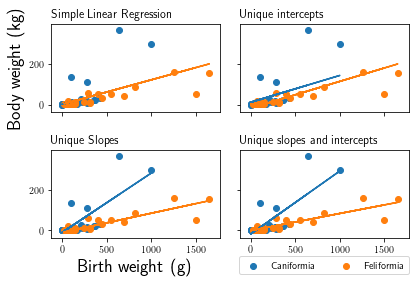

In [4]:
fig, axs = bp.subplots(2, 2, sharex=True, sharey=True)
beta_hats = [beta_hat, beta_hat_ints, beta_hat_slps, beta_hat_ints_slps]
Xs = [X, X_ints, X_slps, X_ints_slps]
titles = ['Simple Linear Regression', 'Unique intercepts', 'Unique Slopes', 'Unique slopes and intercepts']

for a, ax in enumerate(fig.axes):
    bp.current_axis(ax)
    for i, (name, gdf) in enumerate(carn.groupby("SuperFamily")):
        x = gdf["BW"]; y = gdf["SW"]; col = bp.color[i]
        bp.scatter(x, y, color=col, label=name)
        idx = carn["SuperFamily"] == name
        yhat = predict_normal(beta_hats[a], Xs[a][idx,:])
        bp.line(x, yhat, color=col)
        bp.title(titles[a])
        if a == 3:
            bp.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
        

bp.labels(x="", y="Body weight (kg)", size=18, ax=axs[0][0])
bp.labels(x="Birth weight (g)", y="", size=18, ax=axs[1][0])

#handles, labels = axs[1][1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')

bp.tight_layout()

The code above uses the four vectors of estimated coefficients to make a faceted plot, where each panel corresponds to a model.  Each panel is labelled to help you identify what your options are for modeling within the framework of multiple linear regression.

Notice that simple linear regression is as expected, just a single line that represents the estimated relationship between birth weight and body weight for animals of the Order Carnivora.  The panel labeled unique intercepts shows multiple linear regression, where the different Super Families share a common slope but have unique intercepts.  The panel labeled unique slopes shows multiple linear regression, where the different Super Families share a common intercept but have unique slopes.  The panel labeled unique slopes and intercepts shows multiple linear regression, where the different Super Families have unique intercepts and unique slopes.